# Investigation: Hardware Identification via noise fingerprint exploration
The code to produce the circuits is given below. Thereafter the code to run the ideal circuits is given,then the code to run the circuits on hardware, then the code to extract and store the normalised noise profiles.

In [1]:
import qiskit
from qiskit import QuantumCircuit #Aer, IBMQ,
from qiskit.visualization import plot_histogram
from qiskit import transpile
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler

# importing datetime module for now()
import datetime
import matplotlib

## Backends
We ibm_torino is Heron r1, ibm_kingston is Heron r2, ibm_pittsburgh is Heron r3.
Would be interesting to see 2 different hardware with same chip.
https://quantum.cloud.ibm.com/computers

In [2]:
backends = ['ibm_torino','ibm_brisbane']#,'ibm_kingston','ibm_pittsburgh']
#also I think these are the least busy

## Circuits
The circuits are a V shape. They are equivalent to Indentity operations.

![WhatsApp Image 2025-09-13 at 13.21.13_d16e4418.jpg](<attachment:WhatsApp Image 2025-09-13 at 13.21.13_d16e4418.jpg>)
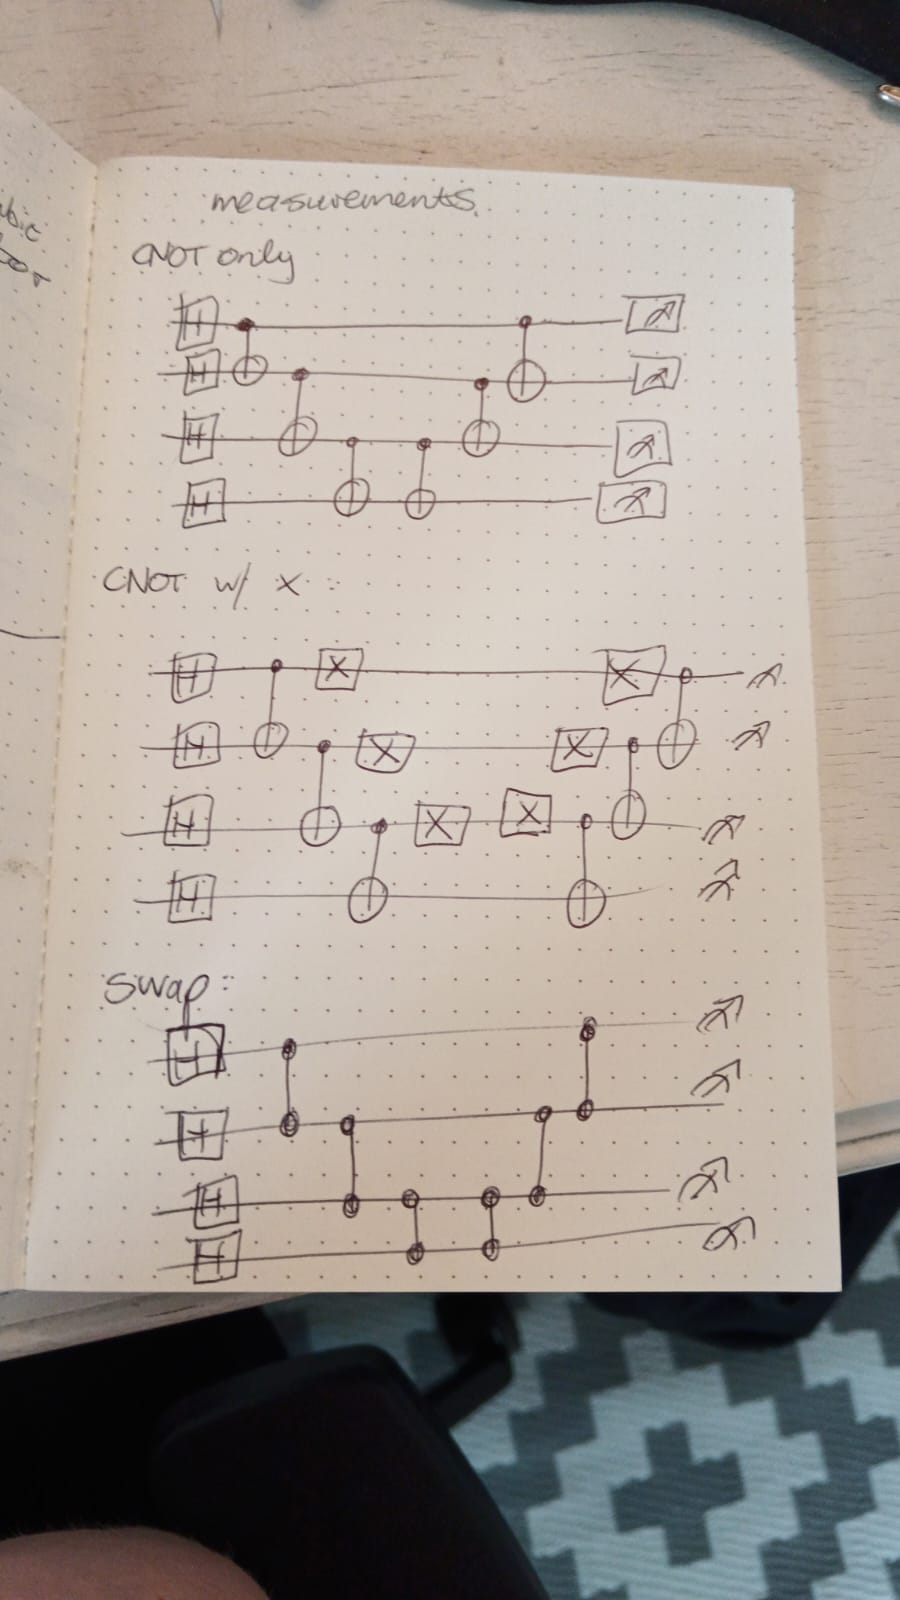

In [3]:
nrs_of_qubits = [4,8,16,32]
circuit_types = ['Cnot','Cnot_X','Swap'] #

In [4]:
#for qubit_nr in nrs_of_qubits:
def make_set_of_3(nr_qubits):
    set_of_3 = []
    for i in range(len(circuit_types)):
        set_of_3.append(make_circuit(nr_qubits,circuit_types[i]))

    return set_of_3

def make_circuit(nr_qubits,circuit_type):
    # make circuit object
    qc = QuantumCircuit(nr_qubits)

    # apply hadamard gates to all qubits
    qc.h(range(nr_qubits))

    #left side of v
    qc = make_left_side(qc,nr_qubits,circuit_type)

    #right side of v
    qc = make_right_side(qc,nr_qubits,circuit_type)

    qc.h(range(nr_qubits))
    #apply measurement gates to all qubits
    qc.measure_all()

    return qc

def make_left_side(qc,nr_qubits,circuit_type):
    #right side of v
    for qubit in range(nr_qubits-1):
        match circuit_type:
            case 'Cnot':
                qc.cx(qubit,qubit+1)
            case 'Cnot_X':
                qc.cx(qubit,qubit+1)
                qc.x(qubit)
            case 'Swap':
                qc.swap(qubit,qubit+1)
    return qc

def make_right_side(qc,nr_qubits,circuit_type):
    #left side of v
    for qubit in range(nr_qubits-2,-1,-1): #start at nr_qubits-1, end at 0, step is -1
        match circuit_type:
            case 'Cnot':
                qc.cx(qubit,qubit+1)
            case 'Cnot_X':
                qc.x(qubit)
                qc.cx(qubit,qubit+1)
            case 'Swap':
                qc.swap(qubit,qubit+1)
    return qc

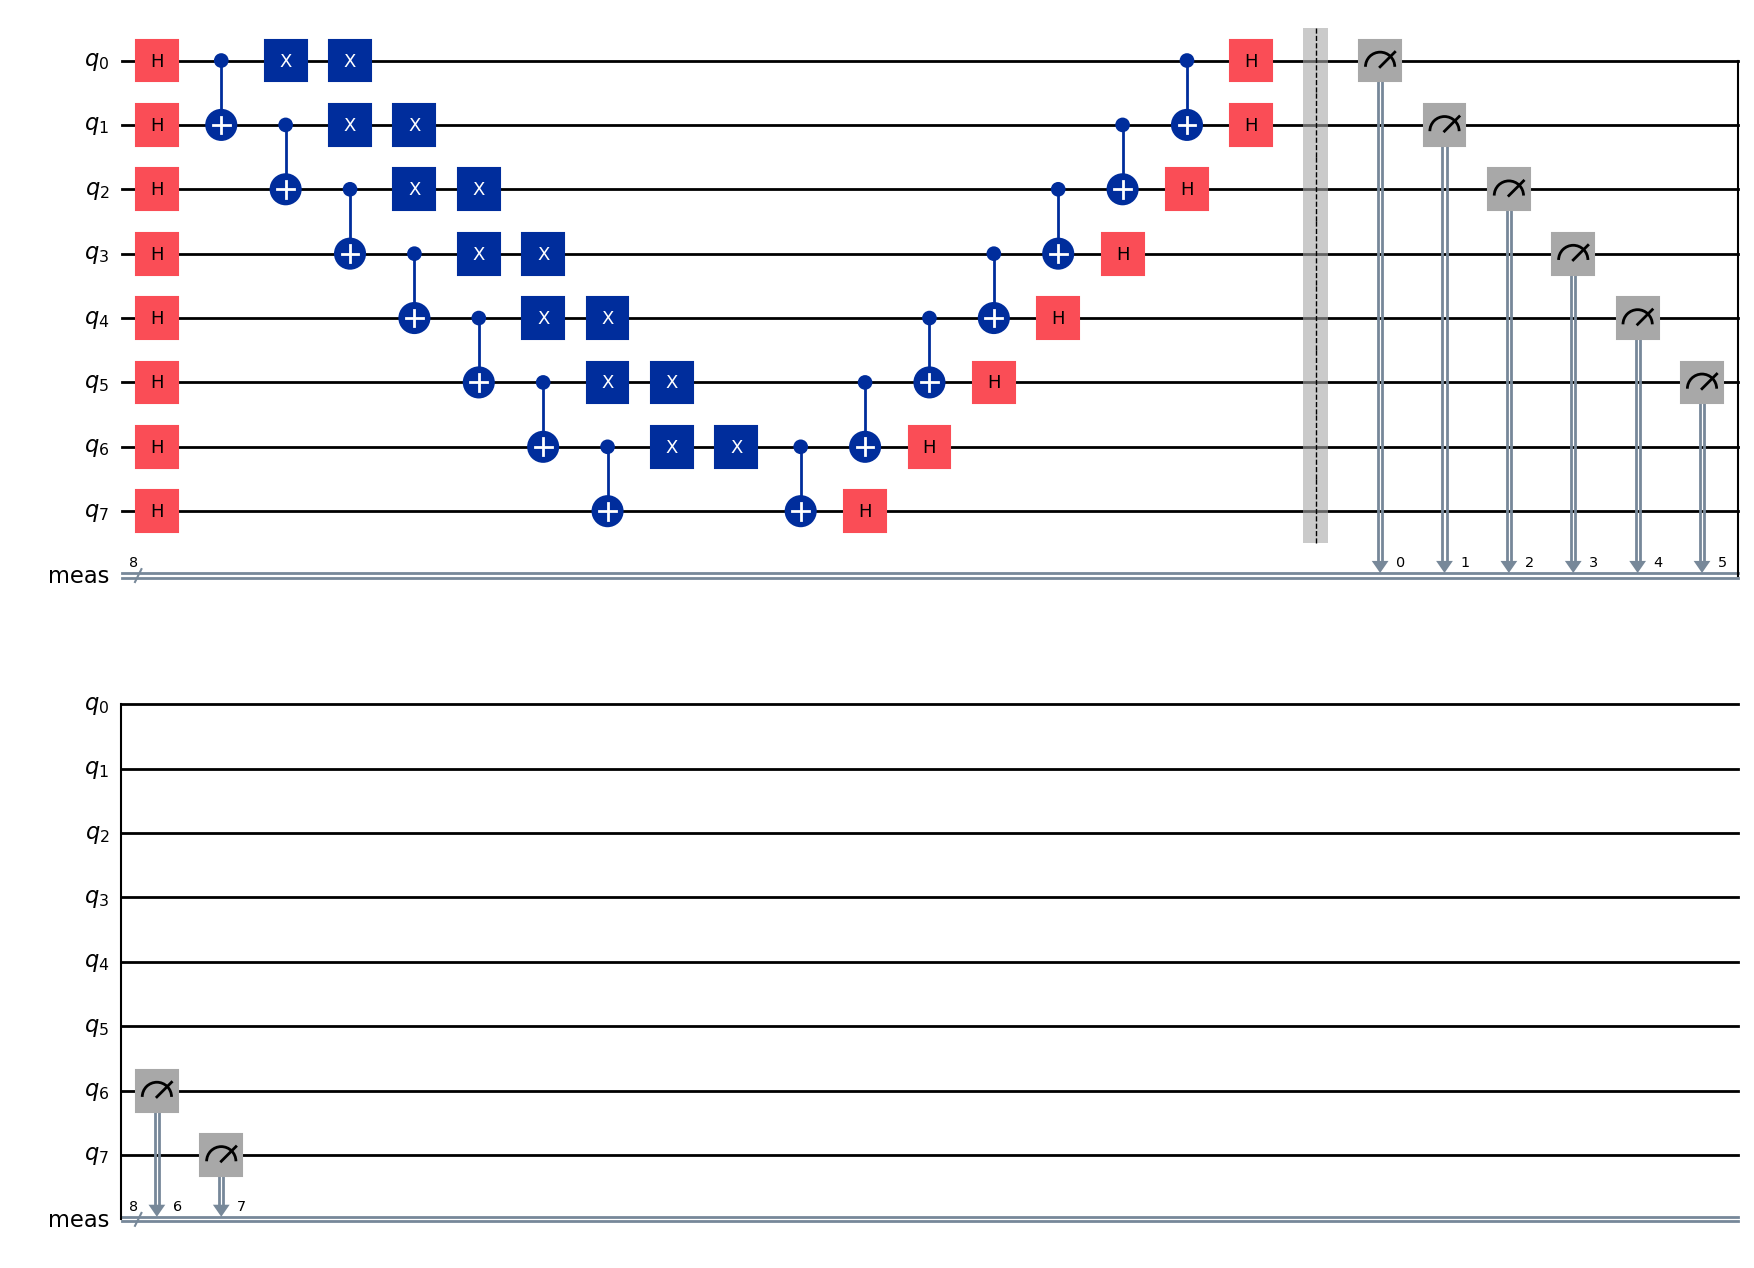

In [5]:
qc = make_circuit(8,'Cnot_X')
qc.draw('mpl')

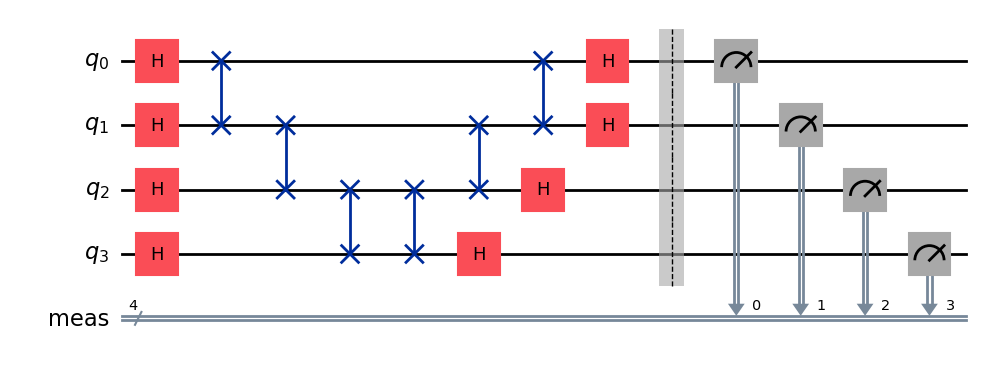

In [6]:
qc_set = make_set_of_3(4)
qc_set[2].draw('mpl')

## Simulated Ideal Results

In [ ]:
# For noisy simulated results
# from qiskit.providers.fake_provider import GenericBackendV2
#sim_backend = GenericBackendV2(num_qubits=4)

{'0000': 1000}


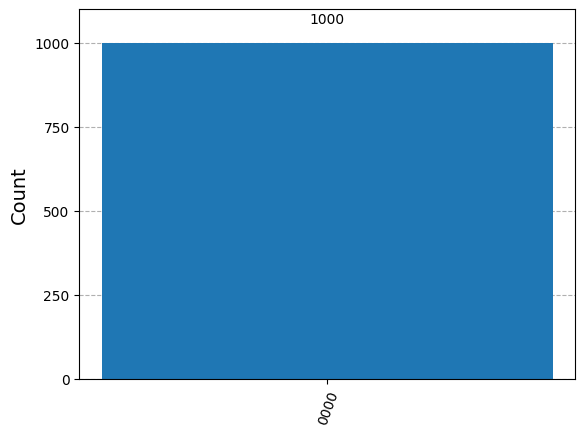

In [7]:
from qiskit.providers.basic_provider import BasicSimulator
nr_qubits= 4
sim_backend = BasicSimulator()
qc_set = make_set_of_3(nr_qubits)[0]

# Transpile the ideal circuit to a circuit that can be directly executed by the backend
transpiled_circuits = transpile(qc_set, sim_backend)

# Run the transpiled circuit using the simulated backend
job = sim_backend.run(transpiled_circuits,shots =1000,memory=True)
result = job.result()

print(result.get_counts())
plot_histogram(result.get_counts())

## Sending Set to IBM backend

In [8]:

def run_job(backend_, circuit_set):
    #transpile circuits
    pm = generate_preset_pass_manager(optimization_level=0, backend=backend_)
    isa_circuits = pm.run(circuit_set)
    sampler = Sampler(mode=backend_)

    #run job
    job = sampler.run(isa_circuits)

    #need code to save job ID
    return job.job_id()

def send_set_to_backends(nr_qubits):
    #make set of circuits:
    qc_set = make_set_of_3(nr_qubits)
    job_IDs = []
    #send set to each backend
    for backend_name in backends:
        #store the job id for each backend job
        job_IDs.append(run_job(service.backend(backend_name),qc_set))
    return job_IDs


#print(f">>> Job ID: {job.job_id()}")
#print(f">>> Job Status: {job.status()}")

service = QiskitRuntimeService()
#comment out when running the job anew
#Job ID: czwqhvq6rr3g008m9h0g
#job = service.job('czwqhvq6rr3g008m9h0g')

Loop for backend runs

In [129]:
def send_and_record(nr_qubits,file_name):
    current_time = datetime.datetime.now().isoformat()
    lines = send_set_to_backends(nr_qubits)
    lines.append(current_time)
    text = "\n".join(lines) + "\n"
    with open(file_name, "a", encoding="utf-8") as f:
        f.write(text)
    return lines

In [ ]:
#simple for loop to make data collection automated

for run in range(2): 
    lines =send_and_record(8,"Job_IDs_Actual8_qubits.txt")
#    status1 = BUSY
 #   status2 = BUSY
  #  while status1 != DONE & status2 != DONE:
   #     job_torino = service.job(lines[0])
    #    status1 =job_torino.status()
     #   job_brisbane = service.job(lines[1])
      #  status2 =job_brisbane.status()


Run the block below to send set to backend :)

In [134]:

# using now() to get current time
nr_qubits =8
current_time = datetime.datetime.now().isoformat()
lines = send_set_to_backends(nr_qubits)


lines.append(current_time)
text = "\n".join(lines) + "\n"
with open("Job_IDs_Actual8_qubits.txt", "a", encoding="utf-8") as f:
    f.write(text)

#with open("file2.txt", "r", encoding="utf-8") as f:
   # print(f.read())

# How to read the results
Format of text file is :
- ibm torino job ID
- ibm brisbane job ID
- date and time of jobs

In [131]:
with open("Job_IDs_8_qubits.txt", "r", encoding="utf-8") as f:
    print(f.read())

d33gqam6pnbs739iina0
d33gqbl0qhlc73cqhulg
2025-09-14T20:44:43.388842
d33gs8u6dbus73d95bng
d33gs9m6pnbs739iip10
2025-09-14T20:48:54.243320
d33gscpmc66s738g5tb0
d33gsdu6dbus73d95bsg
2025-09-14T20:49:12.137250
d33gsgu6pnbs739iip80
d33gsht0qhlc73cqi0jg
2025-09-14T20:49:28.619029
d33gsm1mc66s738g5tjg
d33gsn1mc66s738g5tl0
2025-09-14T20:49:45.297417
d33gsrl0qhlc73cqi0sg
d33gsshmc66s738g5tqg
2025-09-14T20:50:05.462691
d33gt0e6pnbs739iipm0
d33gt166dbus73d95ce0
2025-09-14T20:50:27.870220



Below are just checks for the very first jobs

In [2]:
service = QiskitRuntimeService()
job_torino = service.job('d33bo2m6pnbs739ie5og')
print(f">>> Job Status: {job_torino.status()}")
job_brisbane = service.job('d33bo3u6dbus73d90o50')
print(f">>> Job Status: {job_brisbane.status()}")

>>> Job Status: DONE
>>> Job Status: DONE


In [3]:
print(job_torino.result()[0].data.meas.get_counts())

{'0000': 3330, '0001': 393, '0011': 52, '0010': 206, '0111': 46, '1111': 2, '0100': 38, '0101': 6, '1000': 12, '0110': 6, '1101': 1, '1110': 3, '1100': 1}


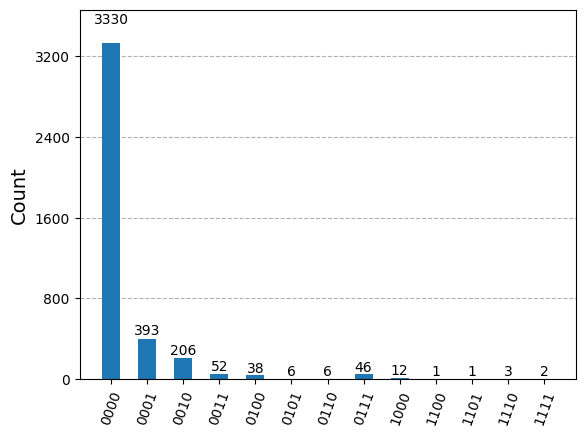

In [105]:
plot_histogram(job_torino.result()[0].data.meas.get_counts())

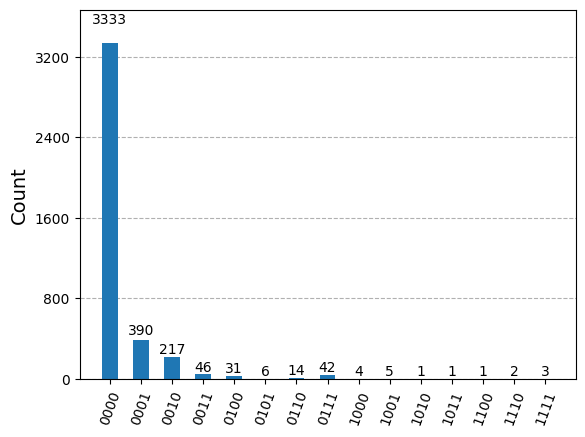

In [106]:
plot_histogram(job_torino.result()[1].data.meas.get_counts())

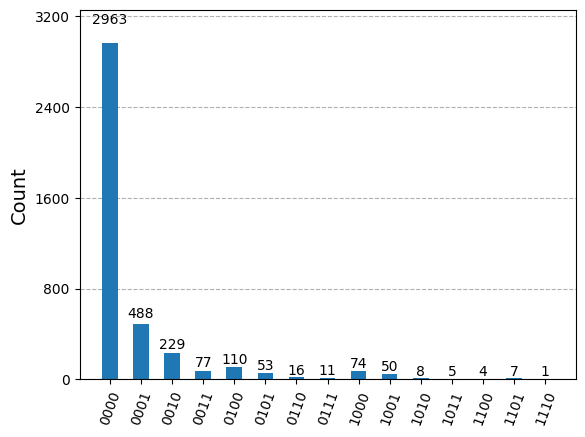

In [107]:
plot_histogram(job_torino.result()[2].data.meas.get_counts())

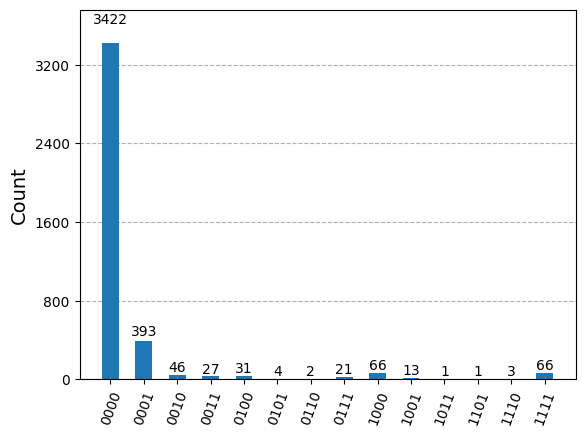

In [108]:
plot_histogram(job_brisbane.result()[0].data.meas.get_counts())

## Extracting Data tests

In [37]:
import csv
from csv import DictWriter
def create_fields(nr_qubits):
    fields = []
    for i in range(2**nr_qubits):
        binary_str = format(i, '0' + str(nr_qubits) + 'b')
        fields.append(binary_str)
    return fields

# print(create_fields(2))
def create_csv(csv_file_name, fields):
    with open(csv_file_name, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(fields)

def results_to_csv(csv_file_names, fields, job_id_file):
    service = QiskitRuntimeService()
    count = 0
    jobs_torino1 = []
    jobs_torino2 = []
    jobs_torino3 = []
    jobs_brisbane1 = []
    jobs_brisbane2 = []
    jobs_brisbane3 = []
    with open(job_id_file, 'r') as f:
        for job_id in f.readlines():
            if count != 2:
                #job_id = f.readline()
                job_id = job_id[:-1] #gets rid of extra blank space character
                #print(job_id)
                #print(len(job_id))
                job = service.job(job_id)
                for i in range(3):
                    #result =i
                    result = job.result()[i].data.meas.get_counts()
                    #print(result)
                    if i == 0:
                        circuit1 = result
                    elif i == 1:
                        circuit2 = result
                    else:
                        circuit3 = result
                if count == 0:
                    jobs_torino1.append(circuit1)
                    jobs_torino2.append(circuit2)
                    jobs_torino3.append(circuit3)
                elif count == 1:
                    jobs_brisbane1.append(circuit1)
                    jobs_brisbane2.append(circuit2)
                    jobs_brisbane3.append(circuit3)
            count = (count + 1) % 3
            #print(count)

        count2 = 0
        for csv_file_name in csv_file_names:
            match count2:
                case 0:
                    rows = jobs_torino1
                case 1:
                    rows = jobs_torino2    
                case 2:
                    rows = jobs_torino3
                case 3:
                    rows = jobs_brisbane1
                case 4:
                    rows = jobs_brisbane2
                case 5:
                    rows = jobs_brisbane3
            with open(csv_file_name, 'a', newline='') as f:
                writer = DictWriter(f, fieldnames=fields)
                writer.writerows(rows)
            count2 += 1

In [ ]:
#service = QiskitRuntimeService()
#job_torino = service.job('d33bo2m6pnbs739ie5og')
fields_ = create_fields(4)
file_names_ = ['8q_torino1.csv','8q_torino2.csv','8q_torino3.csv','8q_brisbane1.csv','8q_brisbane2.csv','8q_brisbane3.csv']


In [40]:

for file_name in file_names_:
    create_csv(file_name,fields_)
    


In [41]:
results_to_csv(file_names_,fields_,'Job_IDs_4qubits.txt')
